### Problem Statement: 
Build a variational autoencoder model to regenerate images of mnist.


### Objective: 
Use PyTorch to build a variational autoencoder model that will generate new images.

### Import the libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Check the current running system

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load the dataset

In [8]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    './data',
        train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

AttributeError: 'Compose' object has no attribute 'Compose'

### Define the parameters

In [5]:
BATCH_SIZE = 64     # number of data points in each batch
N_EPOCHS = 10       # times to run the model on complete data
INPUT_DIM = 28 * 28 # size of each input
HIDDEN_DIM = 256    # hidden dimension
LATENT_DIM = 20     # latent vector dimension
lr = 1e-3           # learning rate

### Create a dataloader

In [6]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

NameError: name 'train_dataset' is not defined

### Build an encoder class

In [1]:
class Encoder(nn.Module):
        ''' This the encoder part of VAE

        '''
        def __init__(self, input_dim, hidden_dim, z_dim):
            '''
            Args:
                input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
                hidden_dim: A integer indicating the size of hidden dimension.
                z_dim: A integer indicating the latent dimension.
            '''
            super().__init__()

            self.linear = nn.Linear(input_dim, hidden_dim)
            self.mu = nn.Linear(hidden_dim, z_dim)
            self.var = nn.Linear(hidden_dim, z_dim)

        def forward(self, x):
            # x is of shape [batch_size, input_dim]

            hidden = F.relu(self.linear(x))
            # hidden is of shape [batch_size, hidden_dim]
            z_mu = self.mu(hidden)
            # z_mu is of shape [batch_size, latent_dim]
            z_var = self.var(hidden)
            # z_var is of shape [batch_size, latent_dim]

            return z_mu, z_var

NameError: name 'nn' is not defined

### Build the decoder class

In [0]:
class Decoder(nn.Module):
        ''' This the decoder part of VAE

        '''
        def __init__(self, z_dim, hidden_dim, output_dim):
            '''
            Args:
                z_dim: A integer indicating the latent size.
                hidden_dim: A integer indicating the size of hidden dimension.
                output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
            '''
            super().__init__()

            self.linear = nn.Linear(z_dim, hidden_dim)
            self.out = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            # x is of shape [batch_size, latent_dim]

            hidden = F.relu(self.linear(x))
            # hidden is of shape [batch_size, hidden_dim]

            predicted = torch.sigmoid(self.out(hidden))
            # predicted is of shape [batch_size, output_dim]

            return predicted

### Build the VAE class which takes an encoder and a decoder

In [0]:
class VAE(nn.Module):

        def __init__(self, enc, dec):
            super().__init__()

            self.enc = enc
            self.dec = dec

        def forward(self, x):
            # encode
            z_mu, z_var = self.enc(x)

            # sample from the distribution having latent parameters z_mu, z_var
            # reparameterize
            std = torch.exp(z_var / 2)
            eps = torch.randn_like(std)
            x_sample = eps.mul(std).add_(z_mu)

            # decode
            predicted = self.dec(x_sample)
            return predicted, z_mu, z_var

In [0]:
# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

# vae
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

### Define the train function

In [0]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, _) in enumerate(train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)
            
        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, z_var = model(x)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)
        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        loss = recon_loss + kl_loss

        # backward pass
        loss.backward()
        train_loss += loss.item()
        
        # update the weights
        optimizer.step()
            

    return train_loss

### Define the test function

In [0]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)
            
            # kl divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
                
            # total loss
            loss = recon_loss + kl_loss
            test_loss += loss.item()

        return test_loss

### Train and test the model

In [0]:
best_test_loss = float('inf')

for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Train Loss: 155.11, Test Loss: 124.48
Epoch 1, Train Loss: 119.65, Test Loss: 114.52
Epoch 2, Train Loss: 113.66, Test Loss: 111.32
Epoch 3, Train Loss: 111.12, Test Loss: 109.47
Epoch 4, Train Loss: 109.65, Test Loss: 108.37
Epoch 5, Train Loss: 108.69, Test Loss: 107.44
Epoch 6, Train Loss: 107.97, Test Loss: 107.26
Epoch 7, Train Loss: 107.45, Test Loss: 106.75
Epoch 8, Train Loss: 107.03, Test Loss: 106.37
Epoch 9, Train Loss: 106.63, Test Loss: 105.97


### Generate and plot the image

torch.Size([1, 20])
torch.Size([28, 28])


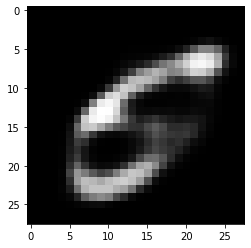

In [0]:
# sample and generate a image
z = torch.randn(1, LATENT_DIM).to(device)

# run only the decoder
reconstructed_img = model.dec(z)
img = reconstructed_img.view(28, 28).data

print(z.shape)
print(img.shape)

plt.imshow(img.cpu(), cmap='gray')